# Loki PredEx
This notebook demonstrates how to run *Loki PredEx* on the normal human heart dataset. It takes about 1 min to run this notebook on MacBook Pro.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

import loki.predex
sc.settings.set_figure_params(dpi=80, facecolor="white")

We provide the image-ST similarity matrix generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_predex/`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the ST gene expression prediction on the human heart dataset:
```
.
├── similarity_matrix
│   └── image_text_similarity.npy
├── training_data
│   ├── all_shared_genes.txt
│   ├── combined_expression_matrix.npy
│   ├── combined_obs.npy
│   └── train_df.csv
└── validation_data
    ├── HCAHeartST11702009.h5ad
    ├── top300_gene_list.npy
    └── val_df.csv                                   
```

In [2]:
data_path = './data/loki_predex/' 

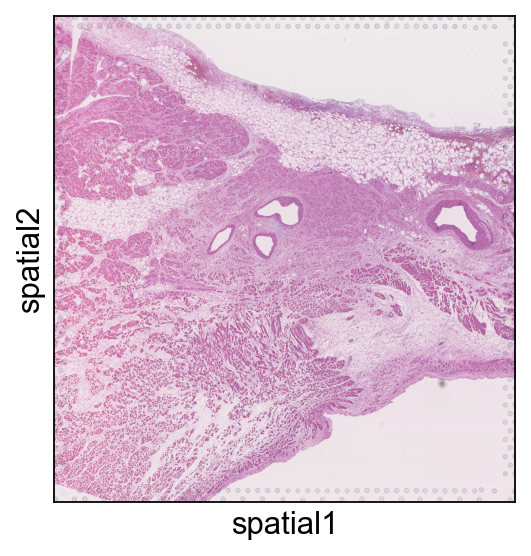

In [3]:
adata = sc.read_h5ad(os.path.join(data_path, 'validation_data', 'HCAHeartST11702009.h5ad'))
genelist = list(np.load(os.path.join(data_path, 'validation_data', 'top300_gene_list.npy'),allow_pickle=True))
ad = adata[:, adata.var_names.isin(genelist)]
sc.pl.spatial(adata, img_key="hires", show=False, spot_size=10)
del adata
val_df = pd.read_csv(os.path.join(data_path, 'validation_data', 'val_df.csv'), index_col=0)
val_spots = val_df.index.tolist()

## Loki PredEx by H&E image
Use Loki PredEx to predict ST gene expression from H&E image.

In [4]:
combined_expression_array = np.load(os.path.join(data_path, 'training_data', 'combined_expression_matrix.npy'))
combined_obs_array = np.load(os.path.join(data_path,'training_data', 'combined_obs.npy'))
train_df = pd.read_csv(os.path.join(data_path, 'training_data', 'train_df.csv'), index_col=0)
train_spots = train_df.index.tolist()
with open(os.path.join(data_path, 'training_data', 'all_shared_genes.txt'), 'r') as f:
    shared_genes = [line.strip() for line in f]

train_indices = np.isin(combined_obs_array, train_spots)
val_indices = np.isin(combined_obs_array, val_spots)

train_data = combined_expression_array[train_indices, :]
val_data = combined_expression_array[val_indices, :]

del combined_expression_array
del train_df

In [5]:
image_text_similarity = np.load(os.path.join(data_path, 'similarity_matrix', 'image_text_similarity.npy'))
predicted_image_text_matrix = loki.predex.predict_st_gene_expr(image_text_similarity, train_data)
prediction = pd.DataFrame(predicted_image_text_matrix, index=val_df.index,columns=shared_genes)
predict_data = prediction[genelist]
predict_data = predict_data.loc[ad.obs_names]
predict_data

APLP2      BEX3     KIF1C    NFKBIA  \
spot_id                                                                         
HCAHeartST11702009_AAACAACGAATAGTTC-1  0.873993  0.570633  0.809642  0.502104   
HCAHeartST11702009_AAACAAGTATCTCCCA-1  0.886108  0.600569  0.823685  0.526464   
HCAHeartST11702009_AAACACCAATAACTGC-1  0.888327  0.585750  0.832512  0.477843   
HCAHeartST11702009_AAACAGAGCGACTCCT-1  0.856133  0.540058  0.783130  0.480710   
HCAHeartST11702009_AAACAGCTTTCAGAAG-1  0.874205  0.568552  0.813926  0.492851   
...                                         ...       ...       ...       ...   
HCAHeartST11702009_TTGTTGTGTGTCAAGA-1  0.894089  0.579132  0.829608  0.511592   
HCAHeartST11702009_TTGTTTCACATCCAGG-1  0.892658  0.595588  0.840894  0.474780   
HCAHeartST11702009_TTGTTTCATTAGTCTA-1  0.885468  0.584947  0.826959  0.487564   
HCAHeartST11702009_TTGTTTCCATACAACT-1  0.887217  0.581479  0.830952  0.470430   
HCAHeartST11702009_TTGTTTGTATTACACG-1  0.880530  0.587205  0.813241  0.511512   

                                          NUCB1       JUN     PSMD8    PTGES3  \
spot_id                                                                         
HCAHeartST11702009_AAACAACGAATAGTTC-1  0.748403  0.493271  0.748796  0.549227   
HCAHeartST11702009_AAACAAGTATCTCCCA-1  0.767610  0.504052  0.797189  0.567454   
HCAHeartST11702009_AAACACCAATAACTGC-1  0.753783  0.492416  0.765825  0.541675   
HCAHeartST11702009_AAACAGAGCGACTCCT-1  0.730232  0.474532  0.718386  0.533094   
HCAHeartST11702009_AAACAGCTTTCAGAAG-1  0.746465  0.484543  0.756364  0.541125   
...                                         ...       ...       ...       ...   
HCAHeartST11702009_TTGTTGTGTGTCAAGA-1  0.768178  0.499199  0.772891  0.574577   
HCAHeartST11702009_TTGTTTCACATCCAGG-1  0.756744  0.500931  0.773873  0.546936   
HCAHeartST11702009_TTGTTTCATTAGTCTA-1  0.755719  0.489815  0.775463  0.542257   
HCAHeartST11702009_TTGTTTCCATACAACT-1  0.749562  0.489309  0.763408  0.535830   
HCAHeartST11702009_TTGTTTGTATTACACG-1  0.758651  0.492912  0.782527  0.551987   

                                         EEF1B2     HADHA  ...       TTN  \
spot_id                                                    ...             
HCAHeartST11702009_AAACAACGAATAGTTC-1  0.932378  1.023527  ...  3.124240   
HCAHeartST11702009_AAACAAGTATCTCCCA-1  0.975902  1.036880  ...  3.118218   
HCAHeartST11702009_AAACACCAATAACTGC-1  0.917877  1.077905  ...  3.162872   
HCAHeartST11702009_AAACAGAGCGACTCCT-1  0.908748  1.009164  ...  3.102248   
HCAHeartST11702009_AAACAGCTTTCAGAAG-1  0.933277  1.039306  ...  3.139337   
...                                         ...       ...  ...       ...   
HCAHeartST11702009_TTGTTGTGTGTCAAGA-1  0.942139  1.041307  ...  3.096955   
HCAHeartST11702009_TTGTTTCACATCCAGG-1  0.911552  1.095047  ...  3.193938   
HCAHeartST11702009_TTGTTTCATTAGTCTA-1  0.937204  1.073276  ...  3.143954   
HCAHeartST11702009_TTGTTTCCATACAACT-1  0.911418  1.086841  ...  3.169456   
HCAHeartST11702009_TTGTTTGTATTACACG-1  0.965851  1.043346  ...  3.107597   

                                          CRYAB       DES      MYH6     TNNT2  \
spot_id                                                                         
HCAHeartST11702009_AAACAACGAATAGTTC-1  3.412881  3.790170  2.929568  3.479691   
HCAHeartST11702009_AAACAAGTATCTCCCA-1  3.477846  3.808141  2.917475  3.476100   
HCAHeartST11702009_AAACACCAATAACTGC-1  3.472018  3.868768  2.871716  3.553461   
HCAHeartST11702009_AAACAGAGCGACTCCT-1  3.388016  3.767592  2.832028  3.452923   
HCAHeartST11702009_AAACAGCTTTCAGAAG-1  3.427375  3.812937  2.882198  3.484470   
...                                         ...       ...       ...       ...   
HCAHeartST11702009_TTGTTGTGTGTCAAGA-1  3.393776  3.846852  2.862902  3.527897   
HCAHeartST11702009_TTGTTTCACATCCAGG-1  3.510115  3.897340  2.844283  3.585431   
HCAHeartST11702009_TTGTTTCATTAGTCTA-1  3.479612  3.848481  2.857775  3.520583   
HCAHeartST11702009_TTGTTTCCATACAACT-1  3.481936  3.877

In [6]:
ad.layers['original'] = ad.X
ad.layers['loki'] = predict_data

/var/folders/f1/0m_1r9dx73dff178jp2t41900000gp/T/ipykernel_85458/3605322198.py:1: ImplicitModificationWarning: Setting element `.layers['original']` of view, initializing view as actual.
  ad.layers['original'] = ad.X


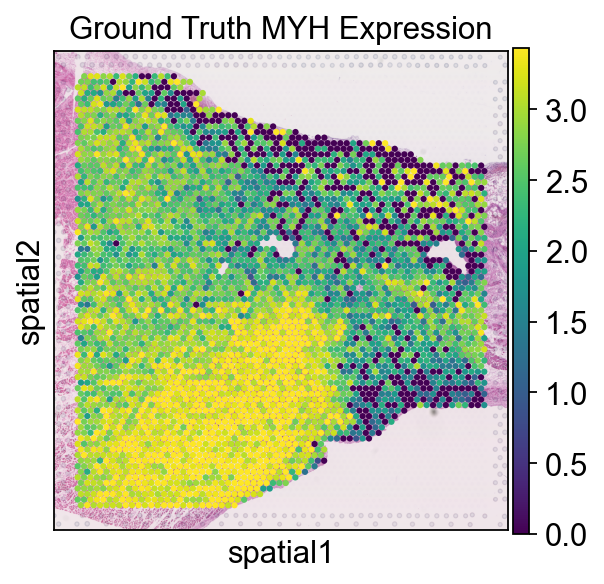

In [7]:
ad.X=ad.layers['original'] 
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Ground Truth MYH Expression')

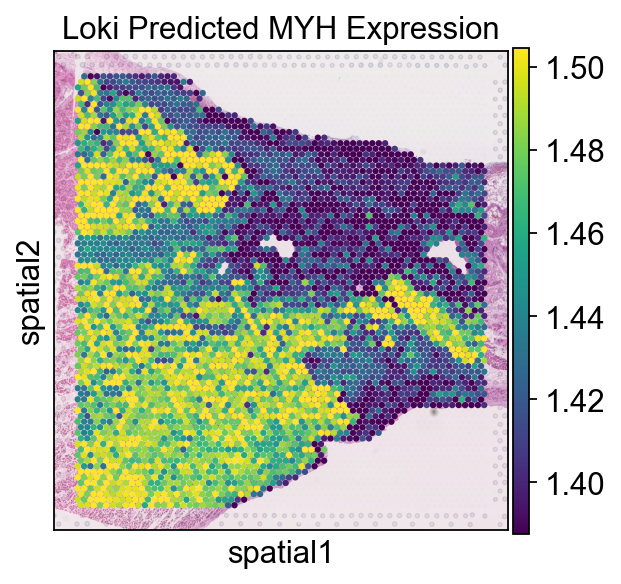

In [8]:
ad.X = ad.layers['loki']
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Loki Predicted MYH Expression')